# Understanding Recurrent Neural Networks with summation of two integers
Name: Sebastian Firsaev 

Student ID: C00263348

Semester: two - 2024

Guide Notebook used: https://github.com/trekhleb/machine-learning-experiments/blob/master/experiments/numbers_summation_rnn/numbers_summation_rnn.ipynb

In this Jupyter notebook, I will explore the capabilities of Recurrent Neural Networks (RNNs) using Long Short-Term Memory (LSTM) units by creating a model to perform summation of two integers represented as strings. The main objective is to construct and train a character-based LSTM model that can accurately process and output the sum of two numbers, each within the range of [1, 99], formatted as a summation expression (e.g., "1+45" or "37+68").


The process will involve gathering a dataset of summation expressions and their corresponding results, which will serve as training data to teach the LSTM model the patterns of arithmetic operations represented as text. Following data collection, I will preprocess the inputs to be suitable for our model, which includes encoding characters into numerical representations.

The next step will be to build the LSTM model using TensorFlow and Keras, focusing on defining an effective architecture, choosing the right hyperparameters, and training the model on our dataset.

Finally, I will evaluate the model’s performance by generating outputs for new summation expressions and analyzing the accuracy of the results in representing the correct sums. 

## What are RNNs?

Recurrent Neural Networks (RNNs) are a class of artificial neural networks designed to handle sequences of data by processing inputs one at a time while maintaining a 'memory' of what has been processed through its internal state or context. Unlike traditional feedforward neural networks, which assume all inputs (and outputs) are independent of each other, RNNs are built to recognize the dynamic temporal behavior of sequential data, making them particularly suited for tasks like speech recognition, language modeling, and time series prediction. In RNNs, the output from one step is fed back into the network as an input for the next step, creating loops within the network which allow information to persist. This looping mechanism enables RNNs to understand and generate predictions based on the entire history of input data, although they can struggle with long-term dependencies due to challenges like vanishing gradients.

##### Re-creation of guide notebook for understanding purposes

## Import dependencies

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import random
import math
import datetime
import keras 

In [3]:
# Load the TensorBoard notebook extension.
# %reload_ext tensorboard
%load_ext tensorboard

## Generate a dataset

In order to train a neural network we need to generate a training dataset which will consist of examples `x` (set of summation expressions) and labels `y` (set of correct answers for each expression). We will start with generating a set of _numbers_ (not strings so far) and than we will convert the sets of numbers into _strings_.

In [4]:
dataset_size = 5000
sequence_length = 2
max_num = 100

In [5]:
# Generates summation sequences and summation results in form of vector if numbers.
def generate_sums(dataset_size, sequence_length, max_num):
    # Initial dataset states.
    x, y = [], []
    
    # Generating sums.
    for i in range(dataset_size):
        sequence = [random.randint(1, max_num) for _ in range(sequence_length)]
        x.append(sequence)
        y.append(sum(sequence))
    
    return x, y

In [6]:
x_train, y_train = generate_sums(
    dataset_size=dataset_size,
    sequence_length=sequence_length,
    max_num=max_num
)

print('x_train:\n', x_train[:3])
print()
print('y_train:\n', y_train[:3])

x_train:
 [[15, 20], [40, 74], [71, 97]]

y_train:
 [35, 114, 168]


In [7]:
# Convert array of numbers for x and y into strings.
# Also it adds a space (" ") padding to strings to make them of the same length. 
def dataset_to_strings(x, y, max_num):
    # Initial dataset states.
    x_str, y_str = [], []
    
    sequnce_length = len(x[0])
    
    # Calculate the maximum length of equation (x) string (i.e. of "11+99")
    num_of_pluses = sequnce_length - 1
    num_of_chars_per_digit = math.ceil(math.log10(max_num + 1))
    max_x_length = sequnce_length * num_of_chars_per_digit + num_of_pluses
    
    # Calculate the maximum length of label (y) string (i.e. of "167")
    max_y_length = math.ceil(math.log10(sequnce_length * (max_num + 1)))
    
    # Add a space " " padding to equation strings to make them of the same length.
    for example in x:
        str_example = '+'.join([str(digit) for digit in example])
        str_example += ''.join([' ' for padding in range(max_x_length - len(str_example))])
        x_str.append(str_example)
    
    # Add a space " " padding to labels strings to make them of the same length.
    for label in y:
        str_example = str(label)
        str_example += ''.join([' ' for padding in range(max_y_length - len(str_example))])
        y_str.append(str_example)
    
    return x_str, y_str

In [8]:
x_train_str, y_train_str = dataset_to_strings(x_train, y_train, max_num)

print('x_train_str:\n', np.array(x_train_str[:3]))
print()
print('y_train_str:\n', np.array(y_train_str[:3]))

x_train_str:
 ['15+20  ' '40+74  ' '71+97  ']

y_train_str:
 ['35 ' '114' '168']


In [9]:
# Since we allow only numbers, plus sign and spaces the vocabulary looks pretty simple.
vocabulary = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', ' ']

In [10]:
# Python dictionary that will convert a character to its index in the vocabulary.
char_to_index = {char: index for index, char in enumerate(vocabulary)}

print(char_to_index)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, ' ': 11}


Our RNN need to have a digits as an input to operate with (and not a strings). To convert summation expressions strings into number the first step we will do is to convert each character of each string into the position index of this character in the `vocabulary`.

In [11]:
# Converts x and y arrays of strings into array of char indices.
def dataset_to_indices(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    char_to_index = {char: index for index, char in enumerate(vocabulary)}
    
    for example in x:
        example_encoded = [char_to_index[char] for char in example]
        x_encoded.append(example_encoded)
        
    for label in y:
        label_encoded = [char_to_index[char] for char in label]
        y_encoded.append(label_encoded)
        
    return x_encoded, y_encoded

In [12]:
x_train_encoded, y_train_encoded = dataset_to_indices(
    x_train_str,
    y_train_str,
    vocabulary
)

print('x_train_encoded:\n', np.array(x_train_encoded[:3]))
print()
print('y_train_encoded:\n', np.array(y_train_encoded[:3]))

x_train_encoded:
 [[ 1  5 10  2  0 11 11]
 [ 4  0 10  7  4 11 11]
 [ 7  1 10  9  7 11 11]]

y_train_encoded:
 [[ 3  5 11]
 [ 1  1  4]
 [ 1  6  8]]


To make our dataset even more understandable for our recurrent neural network we will convert each number into `0/1` [one-hot vector](https://en.wikipedia.org/wiki/One-hot) (i.e. number `1` will be transformed into array `[0 1 0 0 0 0 0 0 0 0 0 0]`).

In [13]:
# Convert x and y sets of numbers into one-hot vectors.
def dataset_to_one_hot(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    for example in x:
        pattern = []
        for index in example:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        x_encoded.append(pattern)
            
    for label in y:
        pattern = []
        for index in label:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        y_encoded.append(pattern)
        
    return x_encoded, y_encoded

In [14]:
x_train_one_hot, y_train_one_hot = dataset_to_one_hot(
    x_train_encoded,
    y_train_encoded,
    vocabulary
)

print('x_train_one_hot:\n', np.array(x_train_one_hot[:1]))
print()
print('y_train_one_hot:\n', np.array(y_train_one_hot[:1]))

x_train_one_hot:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y_train_one_hot:
 [[[0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]


Now we may combine all the function together and create a one function that will do all the work to generate a dataset in the proper format for us.

In [15]:
# Generates a dataset.
def generate_dataset(dataset_size, sequence_length, max_num, vocabulary):
    # Generate integet sum sequences.
    x, y = generate_sums(dataset_size, sequence_length, max_num)
    # Convert integer sum sequences into strings.
    x, y = dataset_to_strings(x, y, max_num)
    # Encode each character to a char indices.
    x, y = dataset_to_indices(x, y, vocabulary)
    # Encode each index into one-hot vector.
    x, y = dataset_to_one_hot(x, y, vocabulary)
    # Return the data.
    return np.array(x), np.array(y)

In [16]:
x, y = generate_dataset(
    dataset_size,
    sequence_length,
    max_num,
    vocabulary
)

print('x:\n', x[:1])
print()
print('y:\n', y[:1])

x:
 [[[0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y:
 [[[0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]


In [17]:
print('x.shape: ', x.shape) # (input_sequences_num, input_sequence_length, supported_symbols_num)
print('y.shape: ', y.shape) # (output_sequences_num, output_sequence_length, supported_symbols_num)

x.shape:  (5000, 7, 12)
y.shape:  (5000, 3, 12)


In [18]:
# How many characters each summation expression has.
input_sequence_length = x.shape[1]

# How many characters the output sequence of the RNN has.
output_sequence_length = y.shape[1]

# The length of one-hot vector for each character in the input (should be the same as vocabulary_size).
supported_symbols_num = x.shape[2]

# The number of different characters our RNN network could work with (i.e. it understands only digits, "+" and " ").
vocabulary_size = len(vocabulary)

print('input_sequence_length: ', input_sequence_length)
print('output_sequence_length: ', output_sequence_length)
print('supported_symbols_num: ', supported_symbols_num)
print('vocabulary_size: ', vocabulary_size)

input_sequence_length:  7
output_sequence_length:  3
supported_symbols_num:  12
vocabulary_size:  12


In [19]:
# Converts a sequence (array) of one-hot encoded vectors back into the string based on the provided vocabulary.
def decode(sequence, vocabulary):
    index_to_char = {index: char for index, char in enumerate(vocabulary)}
    strings = []
    for char_vector in sequence:
        char = index_to_char[np.argmax(char_vector)]
        strings.append(char)
    return ''.join(strings)

In [20]:
decode(y[0], vocabulary)

'82 '

## Build a model

We will use a [Sequential] TensorFlow model with [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers. Logically our model will consist of **encoder** and **decoder**. _Encoder_ will encode the input expression into an array of numbers. And then _decoder_ will try to build an output result sequence by decoding the array of numbers from encoder.

In [21]:
epochs_num = 200
batch_size = 128

In [22]:
model = tf.keras.models.Sequential()

# Encoder
# -------

model.add(tf.keras.layers.LSTM(
    units=128,
    input_shape=(input_sequence_length, vocabulary_size),
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
))

# Decoder
# -------

# We need this layer to match the encoder output shape with decoder input shape.
# Encoder outputs ONE vector of numbers but for decoder we need have output_sequence_length vectors.
model.add(tf.keras.layers.RepeatVector(
    n=output_sequence_length,
))

model.add(tf.keras.layers.LSTM(
    units=128,
    return_sequences=True,
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
))

model.add(tf.keras.layers.TimeDistributed(
    layer=tf.keras.layers.Dense(
        units=vocabulary_size,
    )
))

model.add(tf.keras.layers.Activation(
    activation='softmax'
))

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 12)          │         1,548 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 3, 12)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,324 (802.05 KB)

 Trainable params: 205,324 (802.05 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Train a model

In [25]:
log_dir=".logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy'],
)

In [27]:
history = model.fit(
    x=x,
    y=y,
    epochs=epochs_num,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[tensorboard_callback]
)

Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.1891 - loss: 2.3869 - val_accuracy: 0.3807 - val_loss: 2.0884
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3782 - loss: 1.9990 - val_accuracy: 0.3900 - val_loss: 1.8482
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3815 - loss: 1.8446 - val_accuracy: 0.3940 - val_loss: 1.7756
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3910 - loss: 1.7680 - val_accuracy: 0.3867 - val_loss: 1.7648
Epoch 5/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3921 - loss: 1.7461 - val_accuracy: 0.4093 - val_loss: 1.7043
Epoch 6/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4039 - loss: 1.6954 - val_accuracy: 0.3947 - val_loss: 1.6696
Epoch 7/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4079 - loss: 1.6820 - val_accuracy: 0.4067 - val_loss: 1.6419
Epoch 8/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4173 - loss: 1.6510 - val_accuracy: 0.

In [28]:
# Renders the charts for training accuracy and loss.
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

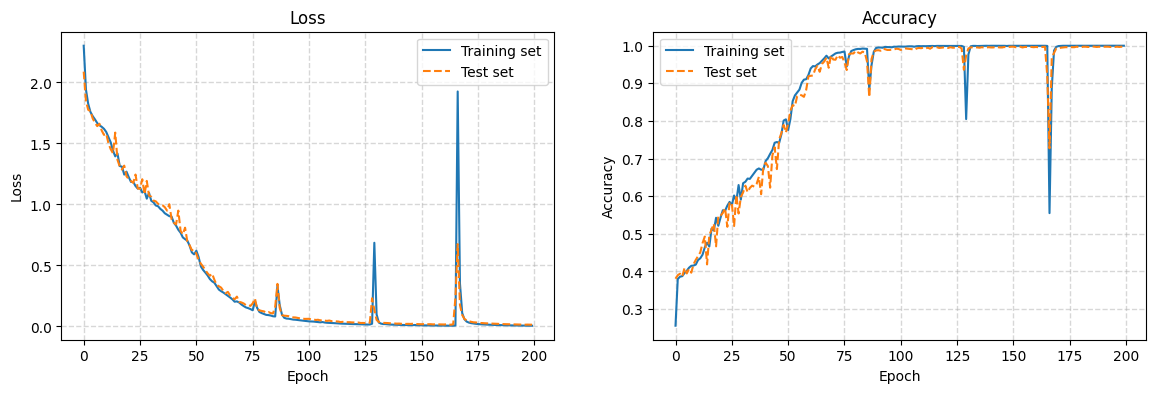

In [29]:
render_training_history(history)

## Test a dataset

In [30]:
x_test, y_test = generate_dataset(dataset_size, sequence_length, max_num, vocabulary)

print('x_test:\n', x_test[:1])
print()
print('y_test:\n', y_test[:1])

x_test:
 [[[0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y_test:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]]]


In [31]:
predictions = model.predict(x_test)

print('predictions.shape: ', predictions.shape)
print()
print('predictions[0]:\n', predictions[0])
print()
print('predictions[1]:\n', predictions[1])

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
predictions.shape:  (5000, 3, 12)

predictions[0]:
 [[2.1496236e-12 1.0000000e+00 9.4836336e-14 2.5760795e-18 2.1197305e-16
  6.1375783e-15 5.8985740e-17 3.2367575e-15 3.7880921e-13 1.2965466e-08
  3.9858972e-16 8.9153765e-17]
 [5.6771881e-07 1.0981058e-04 9.9902952e-01 8.5974950e-04 3.6082585e-07
  8.4899748e-10 1.2792293e-11 6.7853560e-14 3.9379332e-13 5.2479050e-12
  1.2096489e-12 7.6254340e-13]
 [7.8245384e-06 4.8871338e-03 9.9461162e-01 4.9249071e-04 9.1961522e-07
  4.9295759e-09 7.4464893e-11 1.9166907e-13 4.5805469e-12 3.7606238e-09
  3.3038992e-11 2.0024714e-08]]

predictions[1]:
 [[1.56293378e-08 9.99999285e-01 1.80602520e-08 1.18781978e-13
  1.05881397e-11 1.41166578e-10 5.65285110e-11 1.30394562e-09
  5.76982773e-09 6.60727153e-07 1.53721758e-09 3.94355284e-13]
 [1.42273135e-08 4.04415601e-07 1.49093160e-06 1.84962971e-07
  2.58357687e-07 5.67524148e-06 2.89877923e-03 9.96321440e-01
  7.68434082e-04 3.29768432e-06 4.77008877e-10 9.924

In [32]:
x_encoded = [decode(example, vocabulary) for example in x_test]
y_expected = [decode(label, vocabulary) for label in y_test]
y_predicted = [decode(prediction, vocabulary) for prediction in predictions]

explore_num = 40
for example, label, prediction in list(zip(x_encoded, y_expected, y_predicted))[:explore_num]:
    checkmark = '✓' if label == prediction else ''
    print('{} = {} [predict: {}] {}'.format(example, label, prediction, checkmark))

29+93   = 122 [predict: 122] ✓
90+83   = 173 [predict: 173] ✓
41+50   = 91  [predict: 91 ] ✓
19+40   = 59  [predict: 59 ] ✓
10+49   = 59  [predict: 59 ] ✓
10+20   = 30  [predict: 30 ] ✓
3+65    = 68  [predict: 68 ] ✓
78+87   = 165 [predict: 165] ✓
39+25   = 64  [predict: 64 ] ✓
39+94   = 133 [predict: 133] ✓
83+30   = 113 [predict: 113] ✓
24+22   = 46  [predict: 46 ] ✓
34+49   = 83  [predict: 83 ] ✓
69+17   = 86  [predict: 86 ] ✓
94+97   = 191 [predict: 191] ✓
95+70   = 165 [predict: 165] ✓
54+75   = 129 [predict: 129] ✓
87+15   = 102 [predict: 102] ✓
71+68   = 139 [predict: 139] ✓
59+6    = 65  [predict: 65 ] ✓
87+52   = 139 [predict: 139] ✓
12+75   = 87  [predict: 87 ] ✓
40+26   = 66  [predict: 66 ] ✓
13+42   = 55  [predict: 55 ] ✓
25+83   = 108 [predict: 108] ✓
34+24   = 58  [predict: 58 ] ✓
1+39    = 40  [predict: 40 ] ✓
44+87   = 131 [predict: 131] ✓
65+51   = 116 [predict: 116] ✓
26+23   = 49  [predict: 49 ] ✓
86+78   = 164 [predict: 164] ✓
47+94   = 141 [predict: 141] ✓
21+7    

In [85]:
model_name = 'numbers_summation_rnn.h5'
model.save(model_name, save_format='h5')

# Expanding the Notebook by changing the approach

I will explore a "sequence-to-sequence" approach using a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers. The objective is to add two numbers (ranging between 1 and 99) provided as strings (e.g., "1+45", "37+68") and output the result also as a string (e.g., "46", "105"). This model treats each character of the input and output sequences as separate, sequential inputs and outputs, which is a typical application of sequence-to-sequence models.

In [72]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import datetime

### Dataset Generation:

Randomly generate pairs of numbers.Combine pairs into summation strings like "13+8" with varying lengths due to the number nature, and results as strings like "21".

In [73]:
def generate_data(size, max_sum=99):
    """Generates pairs of numbers and their sum as strings."""
    inputs, outputs = [], []
    for _ in range(size):
        a, b = random.randint(1, max_sum), random.randint(1, max_sum)
        inputs.append(f'{a}+{b}')
        outputs.append(str(a + b))
    return inputs, outputs

### Preprocessing:
Convert these string representations into a form suitable for LSTM processing, Pad strings to ensure uniform length.Transform characters into integer indices (encoding).Convert these indices into one-hot encoded vectors.


In [74]:
def preprocess_data(inputs, outputs):
    """Converts strings to one-hot encoded data."""
    all_chars = '0123456789+'
    char_to_int = dict((c, i) for i, c in enumerate(all_chars))
    int_to_char = dict((i, c) for i, c in enumerate(all_chars))

    max_len_input = max([len(i) for i in inputs])
    max_len_output = max([len(o) for o in outputs])

    # Encode input data
    X = np.zeros((len(inputs), max_len_input, len(all_chars)), dtype='float32')
    for i, input_str in enumerate(inputs):
        for t, char in enumerate(input_str):
            X[i, t, char_to_int[char]] = 1

    # Encode output data
    y = np.zeros((len(outputs), max_len_output, len(all_chars)), dtype='float32')
    for i, output_str in enumerate(outputs):
        for t, char in enumerate(output_str):
            y[i, t, char_to_int[char]] = 1

    return X, y, max_len_input, max_len_output, len(all_chars), int_to_char

### Model Architecture

Input: One-hot encoded vectors of characters from the summation strings.
Architecture:
Encoder LSTM: Processes the input sequence and encodes the information in its internal state.
Decoder LSTM: Uses the encoder's output to step-by-step generate the output sequence.
Both LSTMs are followed by a Dense layer with a softmax activation to generate a probability distribution over possible output characters for each position in the output sequence.

In [75]:
# Model building
def build_model(input_len, output_len, num_chars):
    model = Sequential()
    model.add(LSTM(128, input_shape=(input_len, num_chars)))
    model.add(RepeatVector(output_len))
    model.add(LSTM(128, return_sequences=True))
    model.add(TimeDistributed(Dense(num_chars, activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [76]:
def plot_training(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.2291 - loss: 1.9127 - val_accuracy: 0.2330 - val_loss: 1.6700
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2874 - loss: 1.6559 - val_accuracy: 0.4037 - val_loss: 1.6515
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3635 - loss: 1.6317 - val_accuracy: 0.4010 - val_loss: 1.6149
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3653 - loss: 1.6141 - val_accuracy: 0.3683 - val_loss: 1.6008
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3430 - loss: 1.5868 - val_accuracy: 0.2590 - val_loss: 1.5524
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3482 - loss: 1.5177 - val_accuracy: 0.3343 - val_loss: 1.4744
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3671 - loss: 1.4634 - val_accuracy: 0.4180 - val_loss: 1.4216
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4076 - loss: 1.4211 - val_accuracy: 0

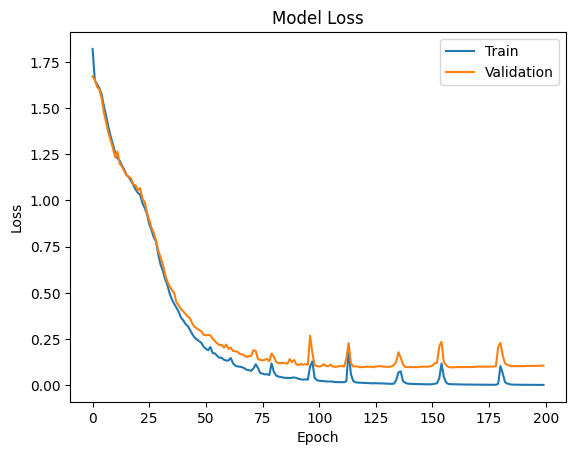

In [80]:
# Data preparation
dataset_size = 5000
inputs, outputs = generate_data(dataset_size)
X, y, input_len, output_len, num_chars, int_to_char = preprocess_data(inputs, outputs)

# Model configuration and training
model = build_model(input_len, output_len, num_chars)
history = model.fit(X, y, epochs=200, batch_size=64, validation_split=0.2)

# Plot training history
plot_training(history)



In [81]:
# Testing and demonstration
example_idx = random.randint(0, len(inputs) - 1)
test_input = X[example_idx:example_idx+1]
prediction = model.predict(test_input)[0]
predicted_sequence = ''.join(int_to_char[np.argmax(vector)] for vector in prediction)

print(f'Input: {inputs[example_idx]}')
print(f'Predicted output: {predicted_sequence}')
print(f'True output: {outputs[example_idx]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
Input: 89+73
Predicted output: 162
True output: 162


In [84]:
import numpy as np

# Function to decode the one-hot encoded strings back to normal strings
def decode_sequence(encoded_seq, int_to_char):
    return ''.join(int_to_char[np.argmax(vector)] for vector in encoded_seq)

# Select and test on 40 random examples from the dataset
test_indices = np.random.choice(len(inputs), size=40, replace=False)
correct_predictions = 0

for idx in test_indices:
    test_input = X[idx:idx+1]
    true_output = outputs[idx]
    prediction = model.predict(test_input)[0]
    predicted_output = decode_sequence(prediction, int_to_char)

    # Calculate accuracy by checking if the predicted and true outputs match
    if predicted_output.strip() == true_output:
        correct_predictions += 1
        checkmark = '✓'
    else:
        checkmark = '✗'

    print(f'Input: {inputs[idx]} => Predicted: {predicted_output.strip()}, True: {true_output} {checkmark}')

# Overall accuracy on the 40 tested examples
print(f'\nAccuracy on 40 samples: {correct_predictions / 40 * 100:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Input: 15+71 => Predicted: 866, True: 86 ✗
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Input: 99+63 => Predicted: 162, True: 162 ✓
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Input: 39+69 => Predicted: 108, True: 108 ✓
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Input: 60+8 => Predicted: 689, True: 68 ✗
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Input: 23+91 => Predicted: 114, True: 114 ✓
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Input: 56+39 => Predicted: 955, True: 95 ✗
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Input: 78+34 => Predicted: 112, True: 112 ✓
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Input: 67+13 => Predicted: 800, True: 80 ✗
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Input: 93+27 => Predicted: 120, True: 120 ✓
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Input: 23+17 => Predicted: 401, True: 40 ✗
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Input: 43+51 => Predicted: 944, True: 94 ✗
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Input: 63+79 => Predicted: 142, True: 142 ✓
1/1 ━━━━━━━━━━━━━━━━━━━

### Discussion

# Expanding the Notebook with Word Generation Using the Shakespeare Dataset

Conclusion and Next Steps

This extension to the original notebook uses Shakespeare database to train an RNN for text generation, showcasing the flexibility of RNNs to adapt to diverse applications, from arithmetic operations to complex text manipulation tasks. The ability to generate plausible new words can be a stepping stone towards more advanced NLP applications like automatic text completion, naming, and creative writing tools.

In [50]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import get_file

# Download Shakespeare dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
shakespeare_path = get_file("shakespeare.txt", shakespeare_url)


In [51]:
# Load and preprocess the text
with open(shakespeare_path, "r", encoding="utf-8") as file:
    shakespeare_text = file.read().lower()

In [64]:
# Displaying random samples from the text
sample_indices = random.sample(range(len(shakespeare_text)), 3)
samples = [shakespeare_text[idx:idx+500] for idx in sample_indices]  # Extract 500 characters from each sample index
for i, sample in enumerate(samples, 1):
    print(f"Sample {i}:\n{sample}\n{'='*50}\n")

Sample 1:
 not their terror.

escalus:
ay, but yet
let us be keen, and rather cut a little,
than fall, and bruise to death. alas, this gentleman
whom i would save, had a most noble father!
let but your honour know,
whom i believe to be most strait in virtue,
that, in the working of your own affections,
had time cohered with place or place with wishing,
or that the resolute acting of your blood
could have attain'd the effect of your own purpose,
whether you had not sometime in your life
err'd in this point

Sample 2:
hat thou art, nought knowing
of whence i am, nor that i am more better
than prospero, master of a full poor cell,
and thy no greater father.

miranda:
more to know
did never meddle with my thoughts.

prospero:
'tis time
i should inform thee farther. lend thy hand,
and pluck my magic garment from me. so:
lie there, my art. wipe thou thine eyes; have comfort.
the direful spectacle of the wreck, which touch'd
the very virtue of compassion in thee,
i have with such provision in

In [65]:
# Character frequency visualization
from collections import Counter
character_counts = Counter(shakespeare_text)
characters = list(character_counts.keys())
frequencies = list(character_counts.values())

In [66]:
# Sorting by frequency
sorted_indices = np.argsort(frequencies)[::-1]
sorted_characters = [characters[idx] for idx in sorted_indices]
sorted_frequencies = [frequencies[idx] for idx in sorted_indices]

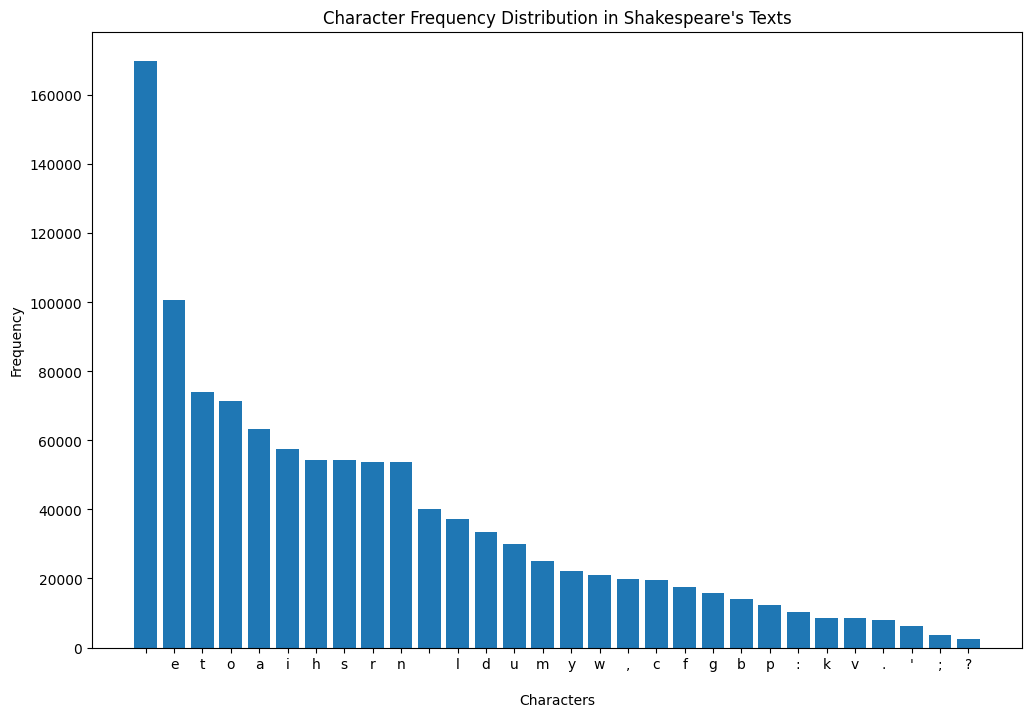

In [67]:
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(sorted_characters[:30], sorted_frequencies[:30])  # Display top 30 characters
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.title('Character Frequency Distribution in Shakespeare\'s Texts')
plt.show()

In [52]:

# Create vocabulary and char-to-index mapping
chars = sorted(list(set(shakespeare_text)))
char_to_index = {char: idx for idx, char in enumerate(chars)}
index_to_char = {idx: char for char, idx in char_to_index.items()}
vocab_size = len(chars)

In [55]:
# Generate sequences
SEQUENCE_LENGTH = 40
step = 3
sequences = []
next_chars = []

for i in range(0, len(shakespeare_text) - SEQUENCE_LENGTH, step):
    sequences.append(shakespeare_text[i : i + SEQUENCE_LENGTH])
    next_chars.append(shakespeare_text[i + SEQUENCE_LENGTH])



In [57]:
# Convert sequences and next_chars to numeric representation
X = np.zeros((len(sequences), SEQUENCE_LENGTH, vocab_size), dtype=bool)
y = np.zeros((len(sequences), vocab_size), dtype=bool)

for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        X[i, t, char_to_index[char]] = 1
    y[i, char_to_index[next_chars[i]]] = 1

In [58]:
# Define the model
model = Sequential([
    LSTM(128, input_shape=(SEQUENCE_LENGTH, vocab_size)),
    Dense(vocab_size, activation='softmax')
])

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [59]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [60]:
# Train the model
model.fit(X, y, batch_size=128, epochs=20)


Epoch 1/20
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 176s 60ms/step - accuracy: 0.2755 - loss: 2.5711
Epoch 2/20
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 201s 59ms/step - accuracy: 0.4118 - loss: 1.9892
Epoch 3/20
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 165s 57ms/step - accuracy: 0.4562 - loss: 1.8201
Epoch 4/20
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 165s 57ms/step - accuracy: 0.4858 - loss: 1.7148
Epoch 5/20
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 165s 57ms/step - accuracy: 0.5018 - loss: 1.6493
Epoch 6/20
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 167s 57ms/step - accuracy: 0.5164 - loss: 1.5988
Epoch 7/20
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 169s 58ms/step - accuracy: 0.5275 - loss: 1.5574
Epoch 8/20
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 171s 59ms/step - accuracy: 0.5357 - loss: 1.5277
Epoch 9/20
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 172s 59ms/step - accuracy: 0.5423 - loss: 1.5028
Epoch 10/20
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 175s 60ms/step - accuracy: 0.5484 - loss: 1.4797
Epoch 11/20
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 176s 61ms/step - accuracy: 0.5523 - loss: 1.46

In [61]:
def generate_text(seed_text, num_chars=100):
    generated_text = seed_text
    for _ in range(num_chars):
        # Encode the seed text
        X_pred = np.zeros((1, SEQUENCE_LENGTH, vocab_size))
        for t, char in enumerate(seed_text):
            X_pred[0, t, char_to_index[char]] = 1
        # Predict the next character
        next_char_prob = model.predict(X_pred, verbose=0)[0]
        next_index = np.random.choice(range(vocab_size), p=next_char_prob)
        next_char = index_to_char[next_index]
        # Update the generated text and seed text
        generated_text += next_char
        seed_text = seed_text[1:] + next_char
    return generated_text

In [62]:
# Generate text using a seed sequence
seed_text = "shall i compare thee to a summer's day?\n"
generated_text = generate_text(seed_text)
print("Generated Text:")
print(generated_text)

Generated Text:
shall i compare thee to a summer's day?
o, that still day i mistress more hie hurg
becomest.

duke vincentio:
mean tilthement; even his pirp


In [63]:
# Save the model
model.save("shakespeare_model.h5")

In [71]:
# Generate text using a seed sequence
seed_text = "that i will come to be death\n"
generated_text = generate_text(seed_text)
print("Generated Text:")
print(generated_text)

Generated Text:
that i will come to be death
esmss mss s issssiei'smisii'iin
ysdmiilli issstssish'asiiddyla.rsdttey!.!ulislltyie
s isimtsmaieiciu
